# SYDE 556/750 --- Assignment 2
**Student ID:  20854840**

*Note:* Please include your numerical student ID only, do *not* include your name.

*Note:* Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_02/syde556_assignment_02.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.

In [1]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import matplotlib.animation as animation


seed = 8955569

# Fix the numpy random seed for reproducible results
np.random.seed(seed)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Generating a random input signal

## 1.1 Band-limited white noise

**a) Time-domain signals.** Plot $x(t)$ for three randomly generated signals with $\texttt{limit}$ at $5$, $10$, and $20\,\mathrm{Hz}$. For each of these, $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$ and $\mathtt{rms}=0.5$.

In [2]:
"""

CONSTANTs


"""

signals = []
limits = [5, 10, 20]
T = 1
dt = 1 / 1000
rms = 0.5

In [3]:
def randComplex():
    return np.random.normal() + np.random.normal() * 1j

#If symmetry exists, it returns a boolean indicating its existence and the index where the symmetric element is located.
def symmetryExists(f, F):
    neg = -f
    return neg in F and f != 0, np.where(F == neg)

# Calculate signal RMS
def signalRMS(signal):
    return np.sqrt(np.mean(np.power(signal, 2)))

# Calculates the current RMS of the signal and then scales all elements to achieve the desired RMS.
def rescaleSignal(signal, idealRMS):
    currentRMS = signalRMS(signal)
    rescaledSignal = [p * idealRMS / currentRMS for p in signal]
    return rescaledSignal

def locations(index):
    return int(index[0])


# It's a way to ensure that the frequency domain and signal values remain aligned.
def tuplify(F, Z):
    return (list(tt) for tt in zip(*sorted(zip(F, Z))))



def generate_signal(T, dt, rms, limit, seed):

    if seed != 0:
        np.random.seed(int(seed))
    # generate a times scale
    timescale = np.arange(0, T, dt)
    # get the number of points so that we can create a signal in the frequency domain
    num_pts = len(timescale)
    # convert to frequency domain
    F = fft.fftfreq(num_pts, dt)
    # create a frequenct signal of zeros
    length_F = len(F)
    # create zeros for the frequency domain
    zeros = np.zeros(length_F)
    Z = zeros.tolist()

    for idx, f in enumerate(F):
        if Z[idx] == 0:
            magnitude_f = abs(f)
            if magnitude_f <= limit:
                im = randComplex()
                Z[idx] = im
                # ensure that we account for the negative symmetric value
                exists, index = symmetryExists(f, F)
                if exists:
                    location = locations(index)
                    # assig it to the complex conjugate
                    Z[location] = np.conj(im)
        else:
            continue
    # perform inverse fft
    z = fft.ifft(Z)
    # select the real components
    z = z.real
    # rescale based on the current and ideal rmse
    z = rescaleSignal(z, rms)

    # convert back to frequency domain
    Z = fft.fft(z)
    # touple Z so that it aligns with our intial number of samples
    F, Z = tuplify(F, Z)
    return z, Z


def plot_signal(signal, domain="time", T=1, dt=1/1000, isBandwidth=False):
    t = np.arange(0, T, dt)
    
    signalData = signal["x"] if domain == "time" else signal["X"]
    signalType = "$x(t)$" if domain == "time" else "$x(ω)$"
    freqLabel = str(signal["freq"]) + " Hz bandwidth" if isBandwidth else str(signal["freq"]) + " Hz limit"
    rmsType = "time-domain" if domain == "time" else "frequency-domain"

    plt.figure()
    plt.plot(t, signalData)
    plt.suptitle(f"{signalType} signal with {freqLabel}")
    plt.xlabel("$t$ (sec)" if domain == "time" else "$ω$ Hz.")
    plt.ylabel(signalType)
    plt.xlim([0, T])
    plt.show()


With these functions, the following are the plots for the given freuqncies


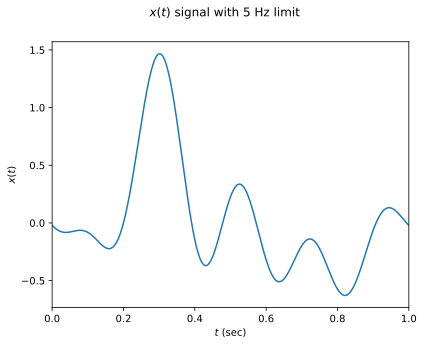

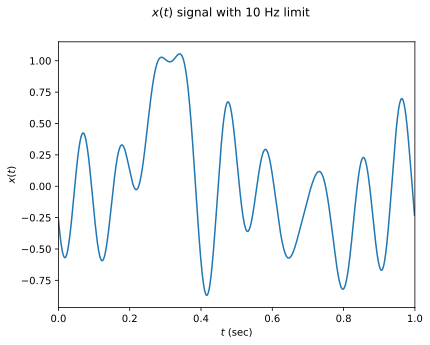

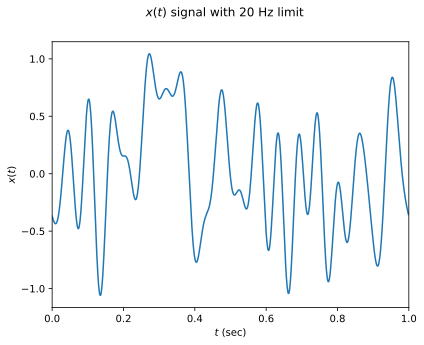

In [4]:
for limit in limits:
    x,X = generate_signal(T,dt,rms,limit,seed)
    signal = {"x": x, "X": X, "freq": limit}
    signals.append(signal)

for signal in signals:
    plot_signal(signal, domain="time", T=T, dt=dt)

**b) Average power spectrum.** Plot the average $|X(\omega)|$ (the norm of the Fourier coefficients, or “power spectrum”) over $100$ signals generated with $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$, $\mathtt{rms}=0.5$, and $\mathtt{limit}=10\,\mathrm{Hz}$ (of course, each of these 100 signals should have a different `seed`). The plot should have the $x$-axis labeled “$\omega$ in radians” and the average $|X|$ value for that $\omega$ on the $y$-axis.

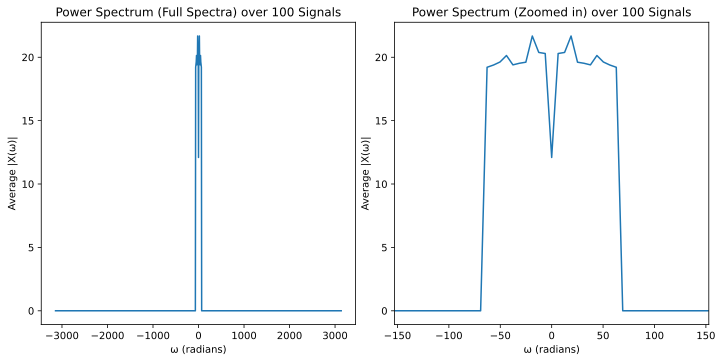

In [5]:
# Define the parameters
T, dt, rms, limit = 1.0, 0.001, 0.1, 10
num_points = 100

# Generate time array
t = np.arange(0, T, dt)
N = len(t)  # Number of samples

# Create a frequency array
f = sorted(np.fft.fftfreq(N, dt))  # Frequencies in Hz
w = [2 * np.pi * freq for freq in f]  # Convert to radians

# Generate an array of unique PRNG seeds
seeds = np.arange(1, num_points, 1)

# Initialize a list to store Fourier coefficients
X_sigs = []

# Loop through each seed and generate signals
for seed in seeds:
    # Generate the signal and obtain its Fourier coefficients
    _, X = generate_signal(T, dt, rms, limit, seed)
    
    # Append the Fourier coefficients to the list
    
    X_sigs.append(X)

# Convert the list of Fourier coefficients to a NumPy array
X_sigs = np.array(X_sigs)

# Calculate the average magnitude of Fourier coefficients across signals
X_sigs_norm = np.abs(X_sigs).mean(axis=0)

# Plot the average magnitudes
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(w,X_sigs_norm)
ax1.set_title('Power Spectrum (Full Spectra) over 100 Signals')
ax1.set_xlabel('ω (radians)')
ax1.set_ylabel('Average |X(ω)|')


ax2.plot(w, X_sigs_norm)
ax2.set_title('Power Spectrum (Zoomed in) over 100 Signals')
ax2.set_xlabel('ω (radians)')
ax2.set_ylabel('Average |X(ω)|')
ax2.set_xlim([-2 * np.pi * limit - 90, 2 * np.pi * limit + 90])


fig.tight_layout(pad=0.5)

## 1.2 Gaussian power spectrum noise

**a) Time-domain signals.** Plot $x(t)$ for three randomly generated signals with `bandwidth` at $5$, $10$, and $20\,\mathrm{Hz}$. For each of these, $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$ and $\mathtt{rms}=0.5$.

In [6]:
def complex_smooth_rand(omega, bandwidth):
    # Calculate the imaginary part of a complex number with smooth random variations
    
    sigma = np.exp((-1 * omega**2) / (2 * bandwidth**2))
    return np.random.normal(scale=sigma) + 1j * np.random.normal(scale=sigma)

def generate_smooth_signal(T, dt, rms, bandwidth, seed):
    # Set the random seed if provided
    if seed != 0:
        np.random.seed(int(seed))

    # Generate a time scale
    timescale = np.arange(0, T, dt)
    num_pts = len(timescale)  # Number of points

    # Convert to frequency domain
    F = fft.fftfreq(num_pts, dt)

    # Create a frequency signal of zeros
    Z = np.zeros_like(F, dtype=complex)

    for idx, f in enumerate(F):
        if Z[idx] == 0:
            im = complex_smooth_rand(omega=f, bandwidth=bandwidth)
            Z[idx] = im

            # Ensure that we account for the negative symmetric value
            exists, index = symmetryExists(f, F)
            if exists:
                location = locations(index)
                # Assign it to the complex conjugate
                Z[location] = np.conj(im)
        else:
            continue

    # Perform inverse FFT
    z = fft.ifft(Z)

    # Select the real components
    z = z.real

    # Rescale based on the current and ideal RMSE
    z = rescaleSignal(z, rms)

    # Convert back to frequency domain
    Z = fft.fft(z)

    # Tuple Z so that it aligns with our initial number of samples
    F, Z = tuplify(F, Z)

    return z, Z

Plotting it out

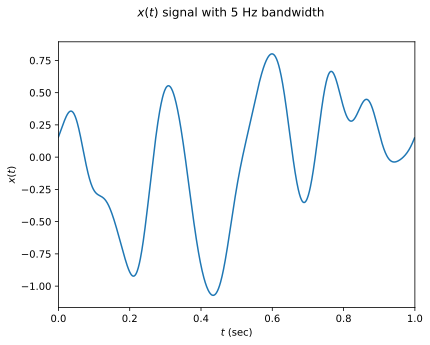

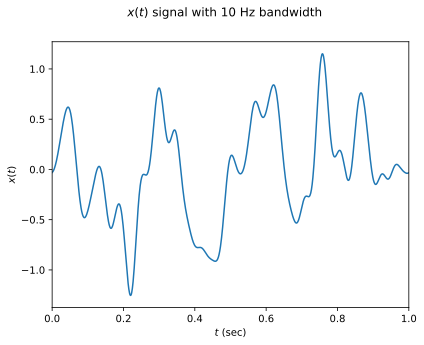

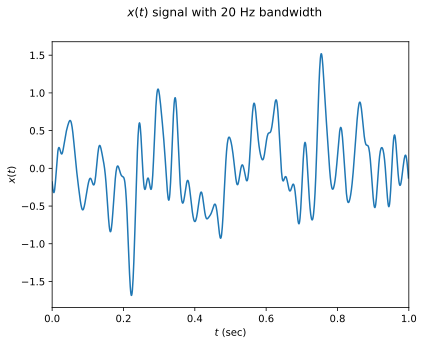

In [7]:
signals = []
bandwidths = [5, 10, 20]
T = 1
dt = 1 / 1000
rms = 0.5

# Generate signals and store them as dictionaries
for bw in bandwidths:
    x, X = generate_smooth_signal(T, dt, rms, bw, seed)  
    signal = {"x": x, "X": X, "freq": bw}
    signals.append(signal)

# Plot the generated signals
for signal in signals:
    plot_signal(signal, domain="time", T=T, dt=dt, isBandwidth=True)

**b) Average power spectrum.** Plot the average $|X(\omega)|$ (the norm of the Fourier coefficients, or “power spectrum”) over $100$ signals generated with $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$, $\mathtt{rms}=0.5$, and $\mathtt{bandwidth}=10$ (of course, each of these 100 signals should have a different `seed`). The plot should have the $x$-axis labeled “$\omega$ in radians” and the average $|X|$ value for that $\omega$ on the $y$-axis.

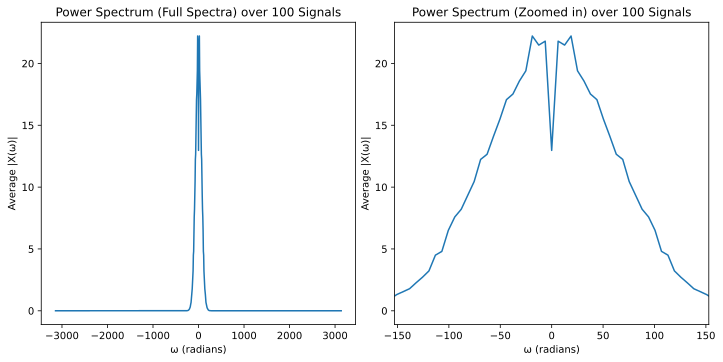

In [8]:
# Define the parameters
T, dt, rms, bandwidth = 1.0, 0.001, 0.1, 10
num_signals = 100

# Generate time array
t = np.arange(0, T, dt)
N = len(t)  # Number of samples

# Create a frequency array
f = sorted(np.fft.fftfreq(N, dt))  # Frequencies in Hz
w = [2 * np.pi * freq for freq in f]  # Convert to radians

# # Generate an array of unique seeds
# seeds = np.zeros(num_signals)
# for i, seed in enumerate(seeds):
#     seeds[i] = int(np.random.randint(1111, 9999))

seeds = np.arange(1, num_signals, 1)

# Initialize a list to store Fourier coefficients
X_sigs = []

# Loop through each seed and generate signals
for seed in seeds:
    # Generate the signal and obtain its Fourier coefficients
    xSeed, X = generate_smooth_signal(T, dt, rms, bandwidth, seed) 
    
    # Append the Fourier coefficients to the list
    X_sigs.append(X)

# Convert the list of Fourier coefficients to an array
X_sigs = np.array(X_sigs)

# Calculate the average magnitude of Fourier coefficients across signals
X_sigs_norm = np.abs(X_sigs).mean(axis=0)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the average power spectrum (full spectra)
ax1.plot(w, X_sigs_norm)
ax1.set_title('Power Spectrum (Full Spectra) over 100 Signals')
ax1.set_xlabel('ω (radians)')
ax1.set_ylabel('Average |X(ω)|')

# Plot the average power spectrum (zoomed in)
ax2.plot(w, X_sigs_norm)
ax2.set_title('Power Spectrum (Zoomed in) over 100 Signals')
ax2.set_xlabel('ω (radians)')
ax2.set_ylabel('Average |X(ω)|')
ax2.set_xlim([-2 * np.pi * bandwidth - 90, 2 * np.pi * bandwidth + 90])

# Adjust the layout of the subplots
fig.tight_layout(pad=0.5)

# 2. Simulating a spiking neuron

**a) Spike plots for constant inputs.** Plot the spike output for a constant input of $x=0$ over $1$ second. Report the number of spikes. Do the same thing for $x=1$. Use a time step of $\Delta t = 1\,\mathrm{ms}$ for the simulation.

In [9]:
minRate = 40 # Hz
maxRate = 150 # you guessed right, also in Hz



class spiking_neuron:
    # Initialize values needed for the spikes
    def __init__(self, e=1, tauRef=0.002, tauRC=0.02):

        self.minRate = minRate
        self.maxRate = maxRate
        self.e = e
        self.tauRef = tauRef
        self.tauRC = tauRC

        
        # calculate gain and bias for the spiking neuron
        self.jBias = 1/(1-np.exp((self.tauRef-(1/self.minRate))/self.tauRC))
        self.alpha = 1/(1-np.exp((self.tauRef-(1/self.maxRate))/self.tauRC))-self.jBias

    
    def spikey(self, x, dt):

        num_refSteps = np.floor(self.tauRef/dt)
        spikeCount = 0
        voltages=[]
        refCount = 0
        V = 0
        vNext = 0
        self.spikes=[]
        
        for stimuli in x:
            J = self.alpha*stimuli*self.e+self.jBias
            if refCount > 0:
                V = 0
                refCount -= 1
                self.spikes.append(0)
            else:
                if V >= 1: # Spike everytime the voltage surpases 1
                    V = 1 # Constant spike voltage for the neuron, picked Vth as designer
                    refCount = num_refSteps
                    spikeCount +=1
                    self.spikes.append(self.e)
                    V=0
                elif V < 0: # Make sure the voltage is positive, else reset to 0
                    self.spikes.append(0)
                    V = 0
                else: self.spikes.append(0)
            vNext = V + dt*(1/self.tauRC)*(J-V) # Next voltage for spike, derived from core diff equation of LIF
            voltages.append(V)
            V = vNext
            spiked = self.spikes


        return voltages, spikeCount, spiked

dt = 0.001
T = 1
t = np.arange(0, T, dt)
n = spiking_neuron()

test=[]
test.append(0)
# In the case for x=0
x_zero = [0 for time in t]
voltage_zero,numSpikes_zero,spike_zero = n.spikey(x_zero, dt)



print("---------------------------------------------")
print("The number of spikes with x = 0 =>", numSpikes_zero)
print("---------------------------------------------")
# In the case for x = 1
x_one = [1 for time in t]
voltage_one, numSpikes_one, spike_one = n.spikey(x_one,dt)
print("---------------------------------------------")
print("The number of spikes with x = 1 =>", numSpikes_one)
print("---------------------------------------------")


---------------------------------------------
The number of spikes with x = 0 => 40
---------------------------------------------
---------------------------------------------
The number of spikes with x = 1 => 143
---------------------------------------------


Plotting the spikes out we get

Text(0, 0.5, 'Voltage V (V)')

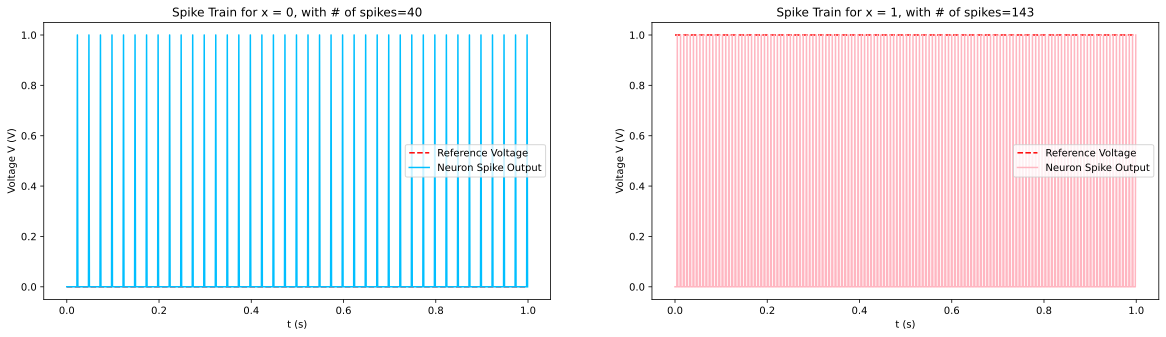

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(t,x_zero, label="Reference Voltage", color="r", linestyle="--")
ax1.plot(t, spike_zero, label="Neuron Spike Output", color="deepskyblue")
ax1.legend()
ax1.set_title("Spike Train for x = 0, with # of spikes="+ str(numSpikes_zero))
ax1.set_xlabel("t (s)")
ax1.set_ylabel("Voltage V (V)")

ax2.plot(t,x_one, label="Reference Voltage", color="red", linestyle="dashed")
ax2.plot(t, spike_one, label="Neuron Spike Output", color="lightpink")
ax2.legend()
ax2.set_title("Spike Train for x = 1, with # of spikes="+ str(numSpikes_one))
ax2.set_xlabel("t (s)")
ax2.set_ylabel("Voltage V (V)")



Now what if we had a smaller step size? This would make the simulation approach continuous time!

We dont have to have to simulate the graphs since the spikes would look the same, but I theorize that we should get more spikes for x=1 case (i.e. get 150 spikes for the 150Hz)

In [11]:
dt = 0.00001
T = 1
t = np.arange(0, T, dt)
n = spiking_neuron()

# In the case for x=0
x_zero_smalldt = [0 for time in t]
voltage_zero_smalldt,numSpikes_zero_smalldt, spike_zero_smalldt = n.spikey(x_zero_smalldt, dt)

print("---------------------------------------------")
print("The number of spikes with x = 0 =>", numSpikes_zero_smalldt)
print("---------------------------------------------")
# In the case for x = 1
x_one_smalldt = [1 for time in t]
voltage_one_smalldt, numSpikes_one_smalldt, spike_one_smalldt  = n.spikey(x_one_smalldt,dt)

print("---------------------------------------------")
print("The number of spikes with x = 1 =>", numSpikes_one_smalldt)
print("---------------------------------------------")

---------------------------------------------
The number of spikes with x = 0 => 40
---------------------------------------------
---------------------------------------------
The number of spikes with x = 1 => 150
---------------------------------------------


VOILA! There you have it, with a way smaller step size, we get the exact number spikes for 150Hz (= 150 spikes!)

Sike i wanted to plot it anyway

Text(0, 0.5, 'Voltage V (V)')

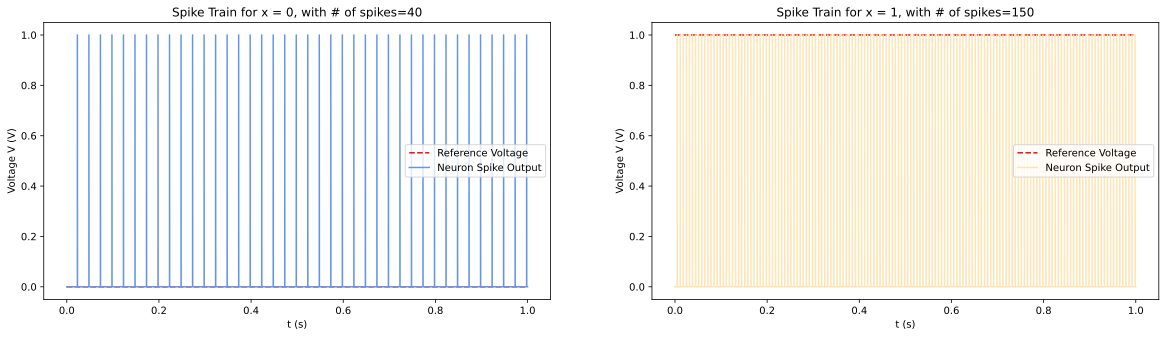

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(t,x_zero_smalldt, label="Reference Voltage", color="r", linestyle="--")
ax1.plot(t, spike_zero_smalldt, label="Neuron Spike Output", color="cornflowerblue")
ax1.legend()
ax1.set_title("Spike Train for x = 0, with # of spikes="+ str(numSpikes_zero_smalldt))
ax1.set_xlabel("t (s)")
ax1.set_ylabel("Voltage V (V)")

ax2.plot(t,x_one_smalldt, label="Reference Voltage", color="red", linestyle="dashed")
ax2.plot(t, spike_one_smalldt, label="Neuron Spike Output", color="moccasin")
ax2.legend()
ax2.set_title("Spike Train for x = 1, with # of spikes="+ str(numSpikes_one_smalldt))
ax2.set_xlabel("t (s)")
ax2.set_ylabel("Voltage V (V)")


So we can summarize our findings into these tables given below

With $\Delta$ t = 0.001
| Numper of spikes With x = 0    | Number of spikes with x = 1 |
| ----------- | ----------- |
| 40   | 143      |





With $\Delta$ t = 0.00001

| Numper of spikes With x = 0    | Number of spikes with x = 1 |
| ----------- | ----------- |
| 40   | 150     |

**b) Discussion.** Does the observed number of spikes in the previous part match the expected number of spikes for $x=0$ and $x=1$? Why or why not? What aspects of the simulation would affect this accuracy?

As we can see in the tables above, for a $\Delta$ t of 0.001, the expected number of spikes for x=0 is 40. It is expected because we have a minimum rate of 40Hz. In contrast to this, if we look at the x=1 case (or 150Hz), we see that we fall short of 7 spikes, and get a total of only 143 spikes! This is less than what we should expect since we are having a maximum rate of 150Hz. This mainly due to $\Delta$ t being large. With a larger $\Delta$ t, it limits the number of spikes that can fit within 1 second.

With a decrease in $\Delta$ t, we can capture finer details of the model's behavior, and the simulation may closely resemble the continuous-time behavior, especially for a case like this. Smaller time steps allow you to better approximate rapid changes in the system's state. This is proven in the second table shown, where for each case, we get 40 spikes and 150 spikes for the x=0 (min rate of 40Hz) and x=1 (max rate of 150Hz) respectively, thereby proving the fact that we should have a smaller step size to be more accurate to the model

**c) Spike plots for white noise inputs.** Plot the spike output for $x(t)$ generated using your function from part 1.1. Use $\mathtt{T}=1\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$, $\mathtt{rms}=0.5$, and $\mathtt{limit}=30\,\mathrm{Hz}$. Overlay on this plot $x(t)$.

Text(0, 0.5, 'Magnitude $x$')

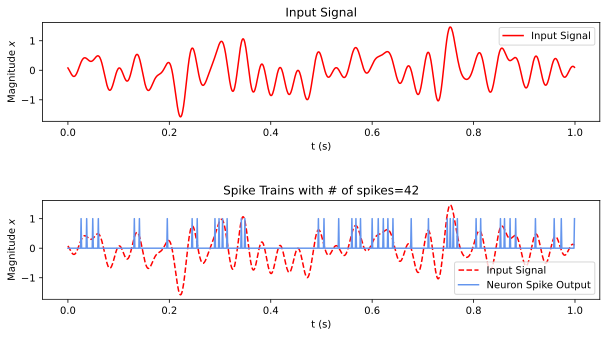

In [13]:
T, dt, rms, limit = 1, 0.001, 0.5, 30
xSpike, XSpike = generate_signal(T, dt, rms, limit, seed)
t = np.arange(0,T,dt)

n = spiking_neuron()

voltage, numSpikes, spikes = n.spikey(xSpike, dt)


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))
plt.subplots_adjust(hspace=0.8)

ax1.plot(t,xSpike, label="Input Signal", color="r")
ax1.legend()
ax1.set_title("Input Signal")
ax1.set_xlabel("t (s)")
ax1.set_ylabel("Magnitude $x$")

ax2.plot(t,xSpike, label="Input Signal", color="r", linestyle="dashed")
ax2.plot(t, spikes, label="Neuron Spike Output", color="cornflowerblue")
ax2.legend()
ax2.set_title("Spike Trains with # of spikes="+ str(numSpikes))
ax2.set_xlabel("t (s)")
ax2.set_ylabel("Magnitude $x$")


**d) Voltage over time.** Using the same $x(t)$ signal as in part *c)*, plot the neuron's voltage over time for the first $0.2$ seconds, along with the spikes over the same time.

To take a closer look at the plot in part c), the $xlim$ function was used to scale the entire plot to have it between 0 and 0.2s

(0.0, 0.2)

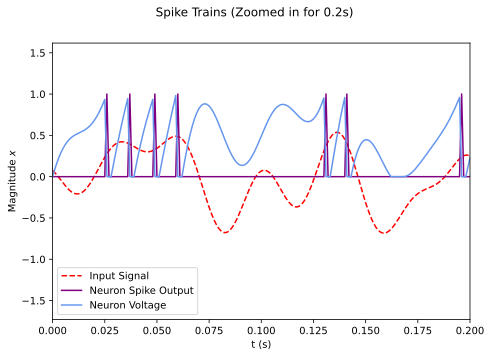

In [14]:
plt.figure(figsize=(7.5,5))
plt.plot(t,xSpike, label="Input Signal", color="r", linestyle="dashed")
plt.plot(t, spikes, label="Neuron Spike Output", color="purple")
plt.plot(t,voltage, label="Neuron Voltage", color="cornflowerblue")
plt.legend()
plt.suptitle("Spike Trains (Zoomed in for 0.2s)")
plt.xlabel("t (s)")
plt.ylabel("Magnitude $x$")
plt.xlim(0,0.2)

**e) 🌟 Bonus question.** How could you improve this simulation (in terms of how closely the model matches actual equation) without significantly increasing the computation time? $0.5$ marks for having a good idea. Up to $1$ mark for actually implementing it and showing that it works.

One excellent method is to implement the Runge-Kutta-Fehlberg  method to improve the simulation without significantly increasing the computation time.

In the context of simulating spiking neuronswhere the precise timing of events and rapid changes in state are important, RKF is a valuable choice due to its ability to adapt to changing dynamics, maintain high accuracy, and ensure stable simulations. It allows you to balance computational efficiency and simulation accuracy effectively, which is crucial in neural modeling where both precision and performance are essential.

In [15]:
class spiking_neuronRKF:
    def __init__(self, e=1, tauRef=0.002, tauRC=0.02, minRate=40, maxRate=150):

        self.minRate = minRate
        self.maxRate = maxRate
        self.e = e
        self.tauRef = tauRef
        self.tauRC = tauRC

        # Calculate gain and bias for the spiking neuron
        self.jBias = 1 / (1 - np.exp((self.tauRef - (1 / self.minRate)) / self.tauRC))
        self.alpha = 1 / (1 - np.exp((self.tauRef - (1 / self.maxRate)) / self.tauRC)) - self.jBias

    def spikey_rkf(self, x, dt):

        num_refSteps = int(np.floor(self.tauRef / dt))
        spikeCount = 0
        voltages = []
        refCount = 0
        V = 0
      
        # Setup constants for RKF computation
        a = [0, 0, 0, 0, 0, 0]
        b = [0, 1/4, 3/8, 12/13, 1, 1/2]
        c = [0, 1/4, 3/8, 12/13, 1, 1]
        d = [0, 25/216, 0, 1408/2565, 2197/4104, -1/5]
        e = [0, 16/135, 0, 6656/12825, 28561/56430, -9/50]

        self.spikes=[]
    
        for stimuli in x:
            J = self.alpha*stimuli*self.e+self.jBias
            if refCount > 0:
                V = 0
                refCount -= 1
                self.spikes.append(0)
            else:
                if V >= 1: # Spike everytime the voltage surpases 1
                    V = 1 # Constant spike voltage for the neuron, picked Vth as designer
                    refCount = num_refSteps
                    spikeCount +=1
                    self.spikes.append(self.e)
                    V=0
                elif V < 0: # Make sure the voltage is positive, else reset to 0
                    self.spikes.append(0)
                    V = 0
                else: self.spikes.append(0)
            vNext = V + dt*(1/self.tauRC)*(J-V) # Next voltage for spike, derived from core diff equation of LIF
            voltages.append(V)
            V = vNext
            spiked = self.spikes
        return voltages, spikeCount, spiked
    

        

In [16]:
'''
# Define time step and duration
dt = 0.001
T = 1

# Create a spiking neuron object with RKF integration
n = spiking_neuronRKF()

# In the case for x = 0
x_zero = [0 for time in np.arange(0, T, dt)]
voltages_zero, numSpikes_zero = n.spikey_rkf(x_zero, dt)

print("---------------------------------------------")
print("The number of spikes with x = 0 =>", numSpikes_zero)
print("---------------------------------------------")

# In the case for x = 1
x_one = [1 for time in np.arange(0, T, dt)]
voltages_one, numSpikes_one = n.spikey_rkf(x_one, dt)

print("---------------------------------------------")
print("The number of spikes with x = 1 =>", numSpikes_one)
print("---------------------------------------------")

'''
# Define time step and duration
dt, T = 0.0001, 1


# Create a spiking neuron object with RKF integration
n = spiking_neuronRKF()

# Generate the time vector
t = np.arange(0, T, dt)

# In the case for x = 0
x_zero = [0] * len(t)
voltages_zero, numSpikes_zero, spike_zero = n.spikey_rkf(x_zero, dt)


print("---------------------------------------------")
print("The number of spikes with x = 0 =>", numSpikes_zero)
print("---------------------------------------------")

# In the case for x = 1
x_one = [1] * len(t)
voltages_one, numSpikes_one, spike_one = n.spikey_rkf(x_one, dt)

print("---------------------------------------------")
print("The number of spikes with x = 1 =>", numSpikes_one)
print("---------------------------------------------")

---------------------------------------------
The number of spikes with x = 0 => 40
---------------------------------------------
---------------------------------------------
The number of spikes with x = 1 => 149
---------------------------------------------


Text(0, 0.5, 'Voltage V (V)')

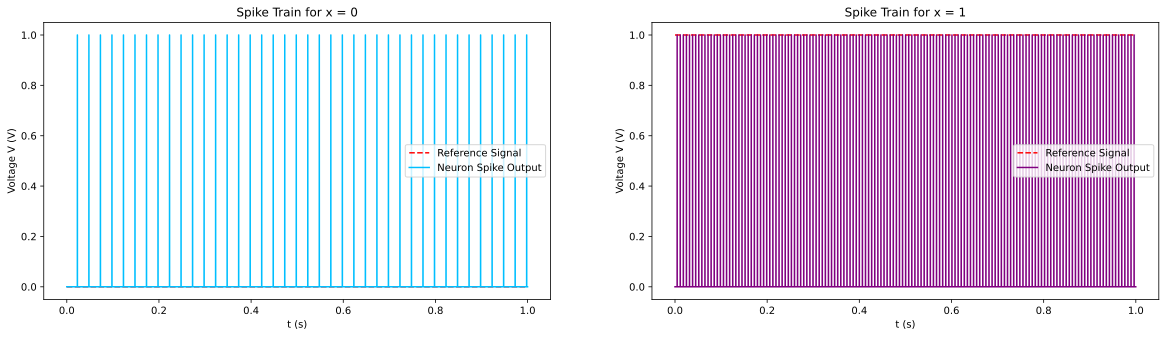

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.plot(t,x_zero, label="Reference Signal", color="r", linestyle="dashed")
ax1.plot(t, spike_zero, label="Neuron Spike Output", color="deepskyblue")
ax1.legend()
ax1.set_title("Spike Train for x = 0")
ax1.set_xlabel("t (s)")
ax1.set_ylabel("Voltage V (V)")

ax2.plot(t,x_one, label="Reference Signal", color="red", linestyle="dashed")
ax2.plot(t, spike_one, label="Neuron Spike Output", color="purple")
ax2.legend()
ax2.set_title("Spike Train for x = 1")
ax2.set_xlabel("t (s)")
ax2.set_ylabel("Voltage V (V)")

(Check with Karim on what the hell this is)

# 3. Simulating two spiking neurons

**a) Spike plots for constant inputs.** Plot $x(t)$ and the spiking output for $x(t)=0$ (both neurons should spike at about $40$ spikes per second), as well as (in a separate plot) $x(t)=1$ (one neuron should spike at $\approx 150$ spikes per second, and the other should not spike at all).

Text(0, 0.5, 'Voltage V (V)')

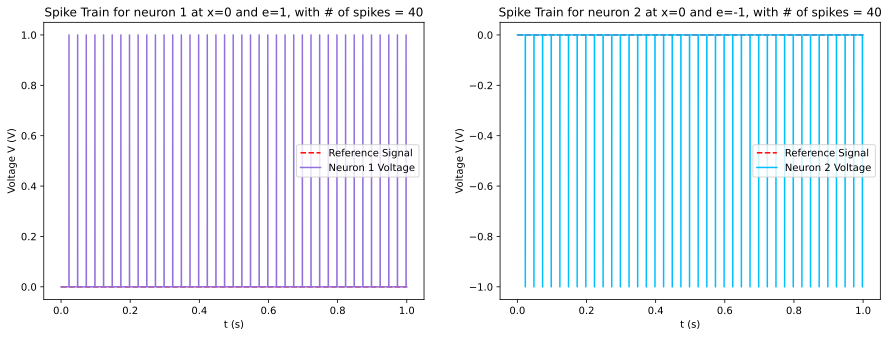

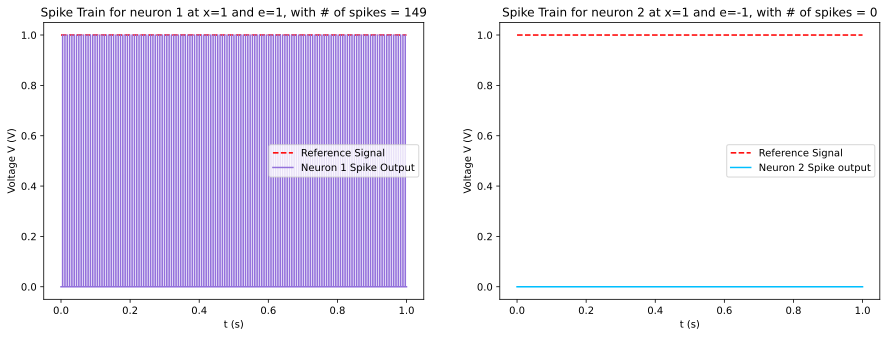

In [18]:
t = np.arange(0,T,dt)

x_spikeNeuron_zero = [0 for time in t]

"""
SIMULATION OF TWO SPIKING NEURONS AT X=0 (40 HZ)

"""


# Neruon for encoder = 1
neuron_one_positive = spiking_neuron(e=1)
voltage_neuron_one_positive, numSpikes_neuron_one_positive, spike_neuron_one_positive = neuron_one_positive.spikey(x_spikeNeuron_zero, dt)

# Neuron for encoder - -1
neuron_two_negative= spiking_neuron(e=-1)
voltage_neuron_two_negative, numSpikes_neuron_two_negative, spike_neuron_two_negative = neuron_two_negative.spikey(x_spikeNeuron_zero,dt)



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(t,x_spikeNeuron_zero, label="Reference Signal", color="r", linestyle="dashed")
ax1.plot(t, spike_neuron_one_positive, label="Neuron 1 Voltage", color="mediumpurple")
ax1.legend()
ax1.set_title("Spike Train for neuron 1 at x=0 and e=1, with # of spikes = "+str(numSpikes_neuron_one_positive))
ax1.set_xlabel("t (s)")
ax1.set_ylabel("Voltage V (V)")

ax2.plot(t,x_spikeNeuron_zero, label="Reference Signal", color="r", linestyle="dashed")
ax2.plot(t, spike_neuron_two_negative, label="Neuron 2 Voltage", color="deepskyblue")
ax2.legend()
ax2.set_title("Spike Train for neuron 2 at x=0 and e=-1, with # of spikes = "+str(numSpikes_neuron_two_negative))
ax2.set_xlabel("t (s)")
ax2.set_ylabel("Voltage V (V)")


"""
SIMULATION OF TWO SPIKING NEURONS AT X=1 (150 HZ)

"""
x_spikeNeuron_one = [1 for time in t]
# Neruon for encoder = 1
neuron_one = spiking_neuron(e=1)
voltage_neuron_one, numSpikes_neuron_one, spike_neuron_one = neuron_one.spikey(x_spikeNeuron_one, dt)


# Neuron for encoder - -1
neuron_two = spiking_neuron(e=-1)
voltage_neuron_two, numSpikes_neuron_two, spike_neuron_two = neuron_two.spikey(x_spikeNeuron_one,dt)


fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 5))

ax3.plot(t,x_spikeNeuron_one, label="Reference Signal", color="r", linestyle="dashed")
ax3.plot(t, spike_neuron_one, label="Neuron 1 Spike Output", color="mediumpurple")
ax3.legend()
ax3.set_title("Spike Train for neuron 1 at x=1 and e=1, with # of spikes = "+str(numSpikes_neuron_one))
ax3.set_xlabel("t (s)")
ax3.set_ylabel("Voltage V (V)")

ax4.plot(t,x_spikeNeuron_one, label="Reference Signal", color="r", linestyle="dashed")
ax4.plot(t, spike_neuron_two, label="Neuron 2 Spike output", color="deepskyblue")
ax4.legend()
ax4.set_title("Spike Train for neuron 2 at x=1 and e=-1, with # of spikes = "+str(numSpikes_neuron_two))
ax4.set_xlabel("t (s)")
ax4.set_ylabel("Voltage V (V)")




I combined these plots together too. The reason why I plotted them as above is to scrutinize the plots and extract information more clearly (see whats going on instead of going into a daze looking at the combined plots)

Text(0, 0.5, 'Voltage V (V)')

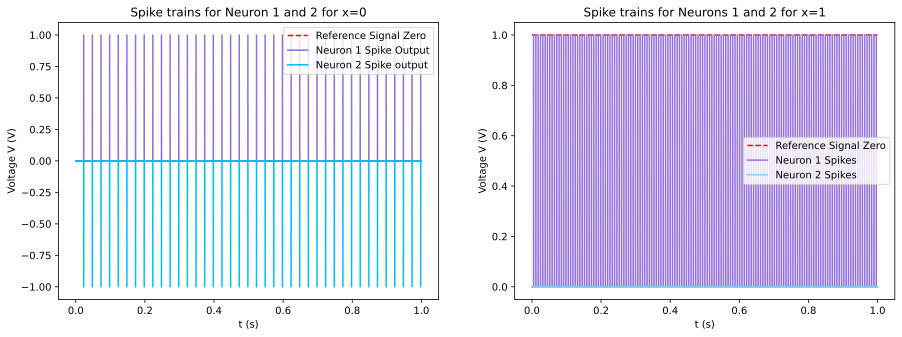

In [19]:

fig, (ax5, ax6) = plt.subplots(1, 2, figsize=(15, 5))


ax5.plot(t,x_spikeNeuron_zero, label="Reference Signal Zero", color = "r", linestyle="dashed")
ax5.plot(t, spike_neuron_one_positive, label="Neuron 1 Spike Output", color="mediumpurple")
ax5.plot(t, spike_neuron_two_negative, label="Neuron 2 Spike output", color="deepskyblue")
ax5.set_title("Spike trains for Neuron 1 and 2 for x=0")
ax5.legend()
ax5.set_xlabel("t (s)")
ax5.set_ylabel("Voltage V (V)")

ax6.plot(t,x_spikeNeuron_one, label="Reference Signal Zero", color = "r", linestyle="dashed")
ax6.plot(t,spike_neuron_one, label="Neuron 1 Spikes", color = "mediumpurple")
ax6.plot(t,spike_neuron_two, label="Neuron 2 Spikes", color ="skyblue" )
ax6.set_title("Spike trains for Neurons 1 and 2 for x=1")
ax6.legend(loc="best")
ax6.set_xlabel("t (s)")
ax6.set_ylabel("Voltage V (V)")

As expected, for the case of x=0, we see both neurons have 40 spikes, but in the case of x=1, the neuron with encoder = 1 has ~ 150 spikes, but the neuron with encoder = -1 has no spikes

**b) Spike plots for a sinusodial input.** Plot $x(t)$ and the spiking output for $x(t)=\frac{1}2 \sin(10 \pi t)$.

[]

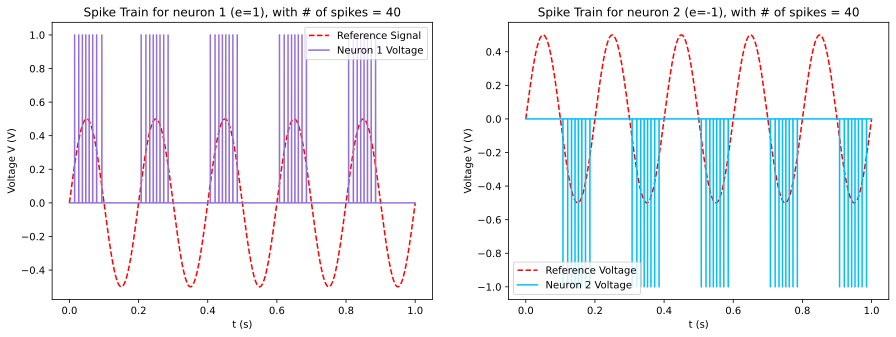

In [20]:
t = np.arange(0,T,dt)

x_sine = 0.5*np.sin(10*np.pi*t)

"""
SIMULATION OF TWO SPIKING NEURONS AT (assuming to be) X=0 (40 HZ) with a sine wave spiking output

"""

neuron_sine_positive_one = spiking_neuron(e=1)

voltage_sine_positive_one, numSpikes_sine_positive_one,spike_sine_positive_one  = neuron_sine_positive_one.spikey(x_sine, dt)

neuron_sine_negative_two = spiking_neuron(e=-1)

voltage_sine_negative_two, numSpikes_sine_negative_two, spiking_sine_negative_two = neuron_sine_negative_two.spikey(x_sine,dt)



fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 5))

ax3.plot(t,x_sine, label="Reference Signal", color="r", linestyle="dashed")
ax3.plot(t, spike_sine_positive_one, label="Neuron 1 Voltage", color="mediumpurple")
ax3.legend()
ax3.set_title("Spike Train for neuron 1 (e=1), with # of spikes = "+str(numSpikes_sine_positive_one))
ax3.set_xlabel("t (s)")
ax3.set_ylabel("Voltage V (V)")

ax4.plot(t,x_sine, label="Reference Voltage", color="r", linestyle="dashed")
ax4.plot(t, spiking_sine_negative_two, label="Neuron 2 Voltage", color="deepskyblue")
ax4.legend()
ax4.set_title("Spike Train for neuron 2 (e=-1), with # of spikes = "+str(numSpikes_sine_negative_two))
ax4.set_xlabel("t (s)")
ax4.set_ylabel("Voltage V (V)")

plt.plot()

Combining these together!

Text(0, 0.5, 'Voltage V (V)')

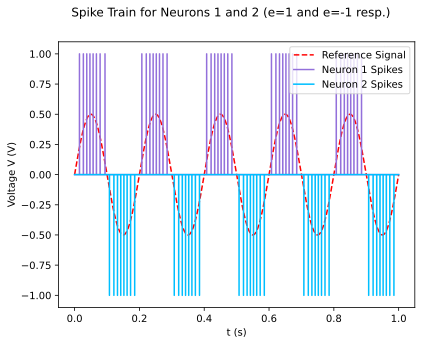

In [21]:
plt.plot(t,x_sine, label="Reference Signal", color="r", linestyle="dashed")
plt.plot(t, spike_sine_positive_one, label="Neuron 1 Spikes", color="mediumpurple")
plt.plot(t, spiking_sine_negative_two, label="Neuron 2 Spikes", color="deepskyblue")
plt.legend()
plt.suptitle("Spike Train for Neurons 1 and 2 (e=1 and e=-1 resp.)")
plt.xlabel("t (s)")
plt.ylabel("Voltage V (V)")

**c) Spike plot for a white noise signal.** Plot $x(t)$ and the spiking output for a random signal generated with your function for question 1.1 with $\mathtt{T}=2\,\mathrm{s}$, $\mathtt{dt}=1\,\mathrm{ms}$, $\mathtt{rms}=0.5$, and $\mathtt{limit}=5\,\mathrm{Hz}$.

Text(0, 0.5, 'Voltage (V)')

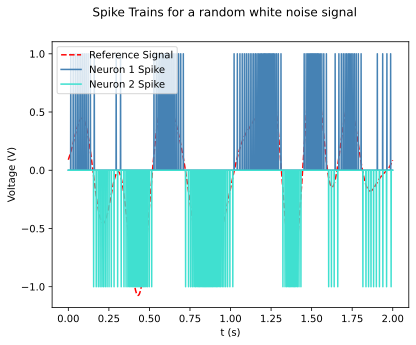

In [22]:
T, dt, rms, limit = 2, 1e-3, 0.5, 5
t = np.arange(0, T, dt)

xWhite, XWhite = generate_signal(T, dt, rms, limit, seed)

neuronOne_white_positive = spiking_neuron(e=1)
neuronTwo_white_negative = spiking_neuron(e=-1)

voltage_white_positive, numSpikes_white_positive, spike_white_positive = neuronOne_white_positive.spikey(xWhite, dt)
voltage_white_negative, numSpikes_white_negative, spike_white_negative = neuronTwo_white_negative.spikey(xWhite,dt)


plt.plot(t, xWhite, label="Reference Signal", linestyle="dashed", color="red")
plt.plot(t,spike_white_positive, label="Neuron 1 Spike", color="steelblue")
plt.plot(t,spike_white_negative, label="Neuron 2 Spike", color="turquoise")
plt.legend()
plt.suptitle("Spike Trains for a random white noise signal")
plt.xlabel("t (s)")
plt.ylabel("Voltage (V)")


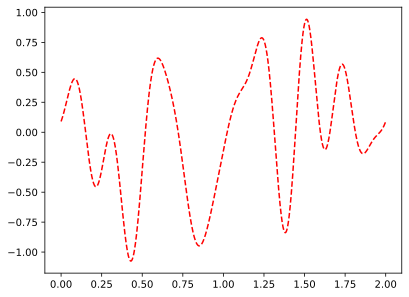

In [23]:
plt.plot(t, xWhite, label="Reference Signal", linestyle="dashed", color="red")
# Just for reference

# 4. Computing an optimal filter

**a) Document the code.** Fill in comments where there are `# !`-signs in the Python code. Make sure that your comments (where this makes sense) describe the semantics of the code and do not just repeat what is obvious from the code itself. Run the function with what you wrote for part 3 above, so that it uses the spike signal generated in 3c).

In [24]:
def compute_optimal_filter(
        # Signal generated from your white noise generator
        x,
        # Fourier coefficients from your white noise generator
        X,
        # Spike train from the previous part
        spikes,
        # Time step size
        dt=1e-3
    ):

    # x and X should (effectively) be 1D-arrays
    assert x.ndim == 1 and X.ndim == 1
    assert x.shape[0] == X.shape[0]

    # Size of the returned signal
    Nt = x.size

    # Make sure that "spikes" is a 2 x Nt array
    assert spikes.ndim == 2
    assert spikes.shape[0] == 2              
    assert spikes.shape[1] == Nt

    # Time T is the number of sample multiplied by the step size
    T = Nt * dt

    # Creates a time scale ts to centre at 0 and between -1 and +1 of the timestep 
    ts = np.arange(Nt) * dt - T / 2.0

    # Frequencies in Hz of the signal (-f_max to +f_max)
    fs = np.arange(Nt) / T - Nt / (2.0 * T)

    # Corresponding frequencies in radians (-w_max to w_max)
    omega = fs * 2.0 * np.pi

    # The response of the two neurons combined together:
    # Nonzero values at each time step when one neuron spiked and the other did not
    r = spikes[0] + spikes[1]

    # Translate this response difference into the frequency domain,
    # This will turn convolution into multiplication and represents spike train power
    R = np.fft.fftshift(np.fft.fft(r))

    # Width of the gaussian window filter in frequency space
    # sigma_t = 1/tau, so with smaller sigma creates larger temporal windows
    sigma_t = 25e-3

    # Gaussian filter, expressing power as a function of the freqency omega
    W2 = np.exp(-omega**2*sigma_t**2)

    # Normalization of the filter from 0 to 1
    W2 = W2 / sum(W2)

    # X(w)*R*(w) represents correlated power between signal and spike train amplitude
    CP = X*R.conjugate()

    # Convolve correlated power with the gaussian to perform windowed filtering
    WCP = np.convolve(CP, W2, 'same')

    # Calculate spike train power |R(w_n:A)|^2 =  R * complex conjugate R
    RP = R*R.conjugate()

    # Convolve spike train power with the gaussian to perform windowed filtering
    WRP = np.convolve(RP, W2, 'same')

    # Convolve the R(w) values for the neuron pair response with the gaussian filter
    XP = X*X.conjugate()

    # Convolve the R(w) values for the neuron pair response with the gaussian filter
    # (not used here, but it could be used to calculate the error in frequency domain)
    WXP = np.convolve(XP, W2, 'same')

    # The optimal temporal filter in the frequency domain
    H = WCP / WRP

    # bring the optimal temporal filter into the time domain,
    # making sure the frequencies line up properly
    h = np.fft.fftshift(np.fft.ifft(np.fft.ifftshift(H))).real

    # Convolve temporal filter and neuron pair response in the frequency domain,
    #returns the temporally filtered estimate for spiking neurons
    XHAT = H*R

    # Bring the frequency domain state estimate into the time domain
    xhat = np.fft.ifft(np.fft.ifftshift(XHAT)).real

    # Return values for the given function
    return ts, fs, R, H, h, XHAT, xhat, XP, WXP, omega, RP

**b) Optimal filter.** Plot the time and frequency plots of the optimal filter for the signal you generated in question 3c). Make sure to use appropriate limits for the $x$-axis.

(-0.5, 0.5)

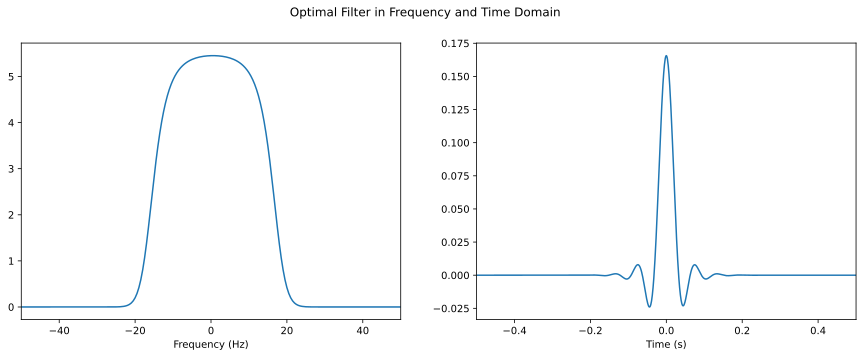

In [25]:
T, dt, rms, limit = 2, 1 / 1000, 0.5, 5

# Converted my lists into an array because i really thought a list would be fine
xWhite_array = np.array(xWhite) 
XWhite_array = np.array(XWhite) 
spikes = np.array([spike_white_negative, spike_white_positive])

ts, fs, R, H, h, XHAT, xHat_white, XP, WXP, omega_white, RP_white = compute_optimal_filter(xWhite_array, XWhite_array, spikes,dt)


H_real = H.real
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Optimal Filter in Frequency and Time Domain")
ax3.plot(fs,H_real, label="Optimal Filter")
ax3.set_xlabel("Frequency (Hz)")
ax3.set_xlim(-50,50)


ax4.plot(ts,h)
ax4.set_xlabel("Time (s)")
ax4.set_xlim(-0.5,0.5)



**c) Decoded signal.** Plot the $x(t)$ signal, the spikes, and the decoded $\hat x(t)$ value for the signal from 3c).

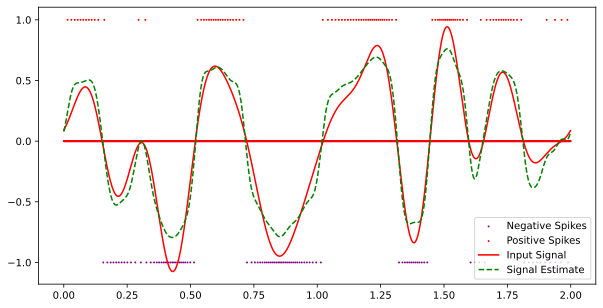

In [26]:
plt.figure(figsize=(10,5))
plt.scatter(t,spike_white_negative, s=1, color="purple", label="Negative Spikes")
plt.scatter(t,spike_white_positive, s=1, color="red",  label="Positive Spikes")
plt.plot(t,xWhite_array, color="red", label="Input Signal")
plt.plot(t,xHat_white, linestyle="dashed", color="green", label="Signal Estimate")
plt.legend(loc="best")


**d) Power spectra.** Plot the signal $|X(\omega)|$, spike response $|R(\omega)|$, and filtered signal $|\hat X(\omega)|$ power spectra for the signal from 3c).

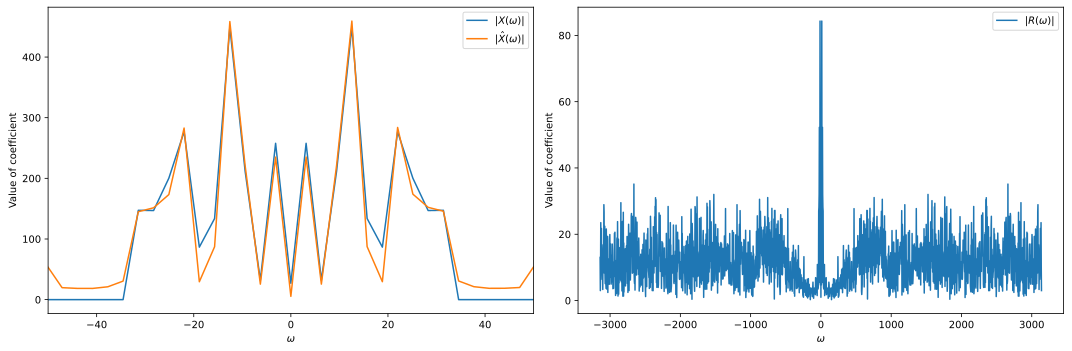

In [27]:
fig=plt.figure(figsize=(15,5))
# plt.title('Frequency Domain')# .real removes unnecessary warnings when plotting
ax=fig.add_subplot(121)
#unsmoothed white noise signal in frequency domain
ax.plot(omega_white,np.sqrt(XP).real, label='$|X(\omega)|$')          
#state estimate in frequency domain
ax.plot(omega_white,np.abs(XHAT).real, label='$|\hat{X}(\omega)|$')   
ax.set_xlabel('$\omega$')
ax.set_ylabel('Value of coefficient')
ax.set_xlim(-50,50)
legend=ax.legend(loc='best') 
ax=fig.add_subplot(122)

#unsmoothed neuron pair spikes frequency domain
ax.plot(omega_white,np.sqrt(RP_white).real, label='$|R(\omega)|$') 
ax.set_xlabel('$\omega$')
ax.set_ylabel('Value of coefficient')
legend=ax.legend(loc='best') 
legend=ax.legend(loc='best') 
legend=ax.legend(loc='best') 
plt.tight_layout()
plt.show()

**e) Discussion.** How do these spectra relate to the optimal filter?

✍ \<YOUR SOLUTION HERE\>

**f) Filter for different signal bandwidths.** Plot the optmial filter $h(t)$ in the time domain when filtering spike trains for white noise signals with different `limit` values of $2\,\mathrm{Hz}$, $10\,\mathrm{Hz}$, and $30\,\mathrm{Hz}$.

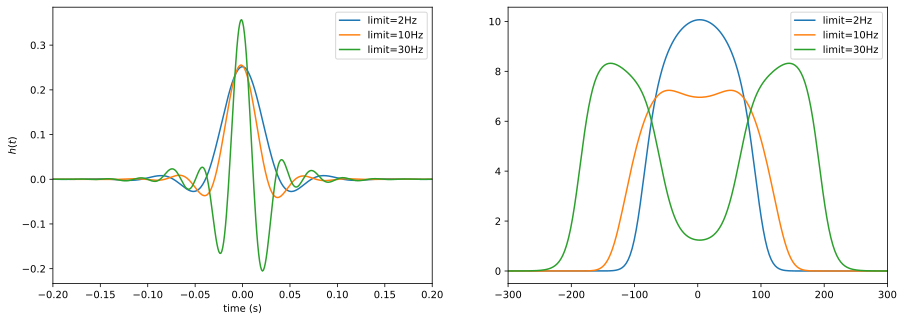

In [28]:
# def generate_optimal_filter(limit):
T, dt, rms, limit = 2, 1e-3, 0.5, 2
#     t = np.arange(0, T, dt)

#     xFilter, XFilter = generate_signal(T,dt,rms,limit,seed)

#     xFilter_array = np.array(xFilter)
#     XFilter_array = np.array(xFilter)

#     neuron_one_positive_filter = spiking_neuron(e=1)
#     neuron_one_negative_filter = spiking_neuron(e=-1)

#     voltage_one_positive_filter, numSpikes_one_positive_filter, spike_one_positive_filter = neuron_one_positive_filter.spikey(xFilter, dt)
#     voltage_one_negative_filter, numSpikes_one_negative_filter, spike_one_negative_filter = neuron_one_negative_filter.spikey(XFilter, dt)

#     spike_neuron_filter = np.array([spike_one_negative_filter,spike_one_positive_filter])

#     ts_filter, fs_filter, R_filter, H_filter, h_filter, XHAT_filter, xHat_filter, XP_filter, WXP_filter, omega_filter, RP_filter = compute_optimal_filter(xFilter_array, XFilter_array, spike_neuron_filter,dt)

#     return ts_filter, fs_filter, R_filter, H_filter, h_filter, XHAT_filter, xHat_filter, XP_filter, WXP_filter, omega_filter, RP_filter
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(15, 5))
ax.set_xlabel('time (s)')
ax.set_ylabel('$h(t)$')
ax.set_xlim(-0.2,0.2)

filters=[]
limits=[2,10,30]


for i in range(len(limits)):
    global seed
    limit=limits[i]
    x,X = generate_signal(T,dt,rms,limit,seed)
    xFilter_array = np.array(x)
    XFilter_array = np.array(X)

    neuron_one_positive_filter = spiking_neuron(e=1)
    neuron_one_negative_filter = spiking_neuron(e=-1)

    voltage_one_positive_filter, numSpikes_one_positive_filter, spike_one_positive_filter = neuron_one_positive_filter.spikey(x, dt)
    voltage_one_negative_filter, numSpikes_one_negative_filter, spike_one_negative_filter = neuron_one_negative_filter.spikey(X, dt)

    spikes=np.array([spike_one_positive_filter,spike_one_negative_filter])

    ts_filter, fs_filter, R_filter, H_filter, h_filter, XHAT_filter, xHat_filter, XP_filter, WXP_filter, omega_filter, RP_filter = compute_optimal_filter(xFilter_array, XFilter_array, spikes,dt)
    ax.plot(ts_filter, h_filter, label='limit=%sHz' %(limits[i]))
    ax1.plot(omega_filter, H_filter.real,label='limit=%sHz' %(limits[i]))
    ax1.set_xlim(-300,300)

ax.legend()
ax1.legend()





    


**g) Discussion.** Describe the effects on the time plot of the optimal filter as `limit` increases. Why does this happen?

✍ \<YOUR SOLUTION HERE\>

# Using post-synaptic currents as a filter


**a) Plotting the filter for different $n$.** Plot the normalized $h(t)$ for $n=0$, $1$, and $2$, with $\tau=7\,\mathrm{ms}$.

<Figure size 640x480 with 0 Axes>

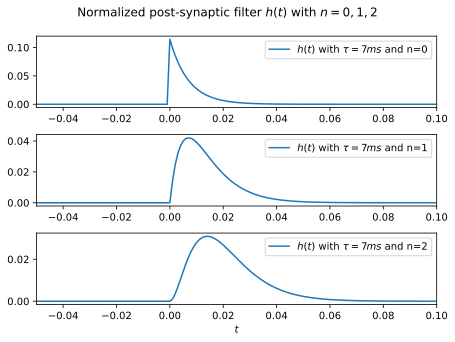

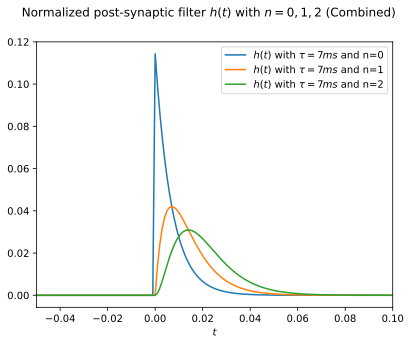

In [29]:
from scipy.integrate import quad


def C(timepoint, nn, ttau):
    return np.power(timepoint, nn) * np.exp(-timepoint / ttau)


def post_synaptic_current_filter(t0=0, T=2, dt=1 / 1000, n=0, tau=7 / 1000):
    t = np.arange(t0, T, dt)
    N = t.size
    h = np.array(np.zeros(N))

    for idx, point in enumerate(h):
        c = quad(C, 0, np.Inf, args=(n, tau))[0]
        h[idx] = np.power(c, -1) * np.power(t[idx], n) * np.exp(-t[idx] / tau)
        if t[idx] < 0:
            h[idx] = 0
    # normalize h
    h = h / (N / 2)
    return h, t


dt = 1 / 1000
tau = 7 / 1000
n_vals = [0, 1, 2]
filters = []
for n in n_vals:
    h, t = post_synaptic_current_filter(t0=-0.5, T=T, dt=dt, n=n, tau=tau)
    filters.append({"h": h, "t": t, "n": n})

plt.figure(1)
fig, ax = plt.subplots(3, 1)
fig.suptitle("Normalized post-synaptic filter $h(t)$ with $n=0,1,2$")
for idx, filter in enumerate(filters):
    a = ax[idx].plot(
        filter["t"],
        filter["h"],
        label="$h(t)$ with $\\tau=7ms$ and n=" + str(filter["n"]),
    )
    ax[idx].axis(xmin=-0.05, xmax=0.1)
    ax[idx].legend(handles=[a], labels=[])
    plt.xlabel("$t$")
fig.tight_layout(pad=1.0)
plt.show()

# Shown all the graph for better inference
plt.figure(2)
plt.suptitle("Normalized post-synaptic filter $h(t)$ with $n=0,1,2$ (Combined)")
handles = []
for idx, filter in enumerate(filters):
    a = plt.plot(
        filter["t"],
        filter["h"],
        label="$h(t)$ with $\\tau=7ms$ and n=" + str(filter["n"]),
    )
    handles.append(a)
plt.legend(handles=handles, labels=[])
plt.xlabel("$t$")
plt.xlim([-0.05, 0.1])
plt.show()

**b) Discussion.** What two things do you expect increasing $n$ will do to $\hat{x}(t)$?

Increasing (the order of the filter) will cause the peak magnitude of the filter to decrease as it increases. It will also cause a delay of the filter window in the direction of positive time. As a result 
experiences a delayed peak magnitude as well, and a smoother onset?

**c) Plotting the filter for different $\tau$.** Plot the normalized $h(t)$ for $\tau=2\,\mathrm{ms}$, $\tau=5\,\mathrm{ms}$, $\tau=10\,\mathrm{ms}$, $\tau=20\,\mathrm{ms}$ with $n = 0$.

In [30]:
# ✍ <YOUR SOLUTION HERE>

**d) Discussion.** What two things do you expect increasing $\tau$ will do to $\hat{x}(t)$?

✍ \<YOUR SOLUTION HERE\>

**e) Decoding a spike-train using the post-synaptic current filter.** Decode $\hat{x}(t)$ from the spikes generated in question 3c) using an $h(t)$ with $n=0$ and $\tau=7\,\mathrm{ms}$. Do this by generating the spikes, filtering them with $h(t)$, and using that as your activity matrix $A$ to compute your decoders. Plot the time and frequency plots for this $h(t)$. Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value.

In [31]:
# ✍ <YOUR SOLUTION HERE>

**f) Deocding a spike-train representing a low-frequency signal.** Use the same decoder and $h(t)$ as in part e), but generate a new $x(t)$ with $\mathtt{limit}=2\,\mathrm{Hz}$. Plot the $x(t)$ signal, the spikes, and the decoded $\hat{x}(t)$ value.

In [32]:
# ✍ <YOUR SOLUTION HERE>

**g) Discussion.** How do the decodings from e) and f) compare? Explain.

✍ \<YOUR SOLUTION HERE\>